In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, precision_recall_curve, average_precision_score
from sklearn.datasets import make_classification

from sklearn.base import BaseEstimator, ClassifierMixin

sns.set_palette('Spectral')

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


---

# <center> Custom Logistic Regression </center>

In [2]:
class CustomLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, number_of_epochs=1000,
                 regularization_strength=0.01, regularize=False, scale=False,
                 verbose=False, log_every=100):
        self.weights_vector = None                  # weights of features (coefficients). shape(n_features,)
        self.bias = None                            # bias (intercept)
        self.learning_rate = learning_rate          # learning rate
        self.number_of_epochs = number_of_epochs    # number of training epochs
        self.final_loss = None                      # last loss value of the model
        self.loss_history = []                      # all losses generated by the model
        self.regularize = regularize                # should the model add regularization
        self.regularization_strength = regularization_strength  # should the model regularize, how strong the regularization be
        self.scale = scale                          # should the model scale the data before fitting
        self.scaler = None                          # the scaler used to scale the model
        self.verbose = verbose                      # print epoch | cost | weights norm
        self.log_every = log_every                  # log how often 

    def _sigmoid(self, z):
        # Activation function to turn the output of the forward propogation (raw values - z) to a probability
        z = np.clip(z, -500, 500)  # Clipping to avoid overflow
        return 1 / (1 + np.exp(-z))
    
    def _log_loss(self, y, y_hat):
        # the cost function of a logistic regression
        epsilon = 1e-10
        mean_loss = -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
        
        if self.regularize:
            l2_penalty = (self.regularization_strength / 2) * np.sum(self.weights_vector ** 2)
            return mean_loss + l2_penalty
        else:
            return mean_loss
    
    def _forward_propagation(self, X, y):
        z = X @ self.weights_vector + self.bias  # (n_samples x n_features) @ (n_features,) --> shape(n_samples,)
        y_hat = self._sigmoid(z)  # outputs probability for each row(sample) in X
        loss = self._log_loss(y, y_hat)
        self.loss_history.append(loss)
        
        return y_hat, loss

    def _back_propagation(self, X, y, y_hat):
        error = y_hat - y  # shape(n_samples,)
        bias_derivative = np.mean(error)  # bias not affected by regularization
        
        number_of_samples = X.shape[0]

        if self.regularize:
            weights_derivative = ( X.T @ error ) / number_of_samples + ( self.regularization_strength * self.weights_vector )  # shape(n_features,)
        else:
            weights_derivative = X.T @ (error) / number_of_samples
        
        return weights_derivative, bias_derivative 

    def _update(self, weights_derivative, bias_derivative):
        self.weights_vector = self.weights_vector - self.learning_rate * weights_derivative
        self.bias = self.bias - self.learning_rate * bias_derivative
        
    def fit(self, X, y):
        if self.scale:  # assumes the split happended before calling fit
            self.scaler = StandardScaler() 
            X = self.scaler.fit_transform(X)

        self.weights_vector = np.zeros(X.shape[1])  # shape(n_features,) because there's only one output per sample. If multiclass, then shape(n_features, k) where k is the number of classes
        self.bias = 0  # single value because there's only one output per sample. If multiclass, then shape(k, ), where k is the number of classes
        
        for epoch in range(self.number_of_epochs):
            y_hat, loss = self._forward_propagation(X, y)
            weights_derivative, bias_derivative = self._back_propagation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

            if self.verbose and (epoch % self.log_every == 0 or epoch == self.number_of_epochs - 1):
                # print(f'Epoch: {epoch} | Loss: {loss} | Weights Norm: {np.linalg.norm(self.weights_vector):.2f}')
                print(f"Epoch {epoch:<5} | Loss: {loss:.5f} | Weights Norm: {np.linalg.norm(self.weights_vector):.5f}")

        self.final_loss = loss
        
        return self
    
    def predict_probability(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        z = X @ self.weights_vector + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        probabilites = self.predict_probability(X)
        return (probabilites >= 0.5).astype(int)

    def inverse_transform(self):
        if self.scale == False or self.scaler is None:
            raise ValueError('Data was not scaled, so it cannot be inverse transformed')
        standard_deviations = self.scaler.scale_
        original_weights = self.weights_vector / standard_deviations
        means = self.scaler.mean_
        original_intercept = self.bias - np.sum(self.weights_vector * means / standard_deviations)
        return original_weights, original_intercept

    def plot_losses(self, ax=None):
        '''
            Plot losses over the epochs as the model is training
        '''

        if ax is None:
            ax = plt.gca()

        ax.plot(self.loss_history, label=f'Final loss: {self.final_loss:.2f}')
        
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss Over Epochs')
        ax.legend()
        ax.grid()



# <center> Compare CustomLogisticRegression with Sklearn Logistic Regression

#### 1. Generate synthetic data

In [3]:
features_synthetic, target_synthetic = make_classification(n_samples=30000,
                                                           n_features=15,  
                                                           n_informative=10,
                                                           n_classes=2,
                                                           random_state=42)

#### 2. Split the data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features_synthetic,
                                                    target_synthetic,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

#### 3. Fit and predict with the model

In [5]:
custom_log_reg = CustomLogisticRegression(verbose=False, regularize=True, number_of_epochs=500, learning_rate=0.1, regularization_strength=0.01).fit(X_train, y_train)
custom_predictions = custom_log_reg.predict(X_test)
custom_probabilities = custom_log_reg.predict_probability(X_test)

#### 4. Evaluation plots

In [6]:
import sys
sys.path.append('../')

from my_utils.classification_eval_plots import EvaluationPlots

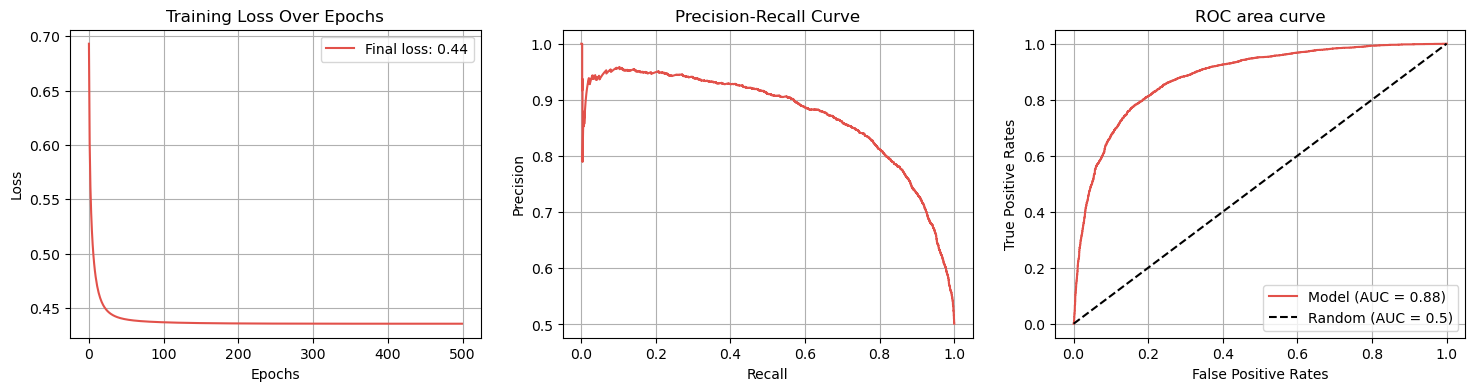

In [7]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
custom_log_reg.plot_losses(ax=axes[0])
EvaluationPlots.plot_precision_recall_curve(y_test, custom_probabilities, ax=axes[1])
EvaluationPlots.plot_roc_area_curve(y_test, custom_probabilities, ax=axes[2])

#### 5. Fit and predict with sklearn logistic regression

In [8]:
sklearn_log_reg = LogisticRegression().fit(X_train, y_train)
sklearn_predictions = sklearn_log_reg.predict(X_test)
sklearn_probabilities = sklearn_log_reg.predict_proba(X_test)

#### 6. Evaluation plots

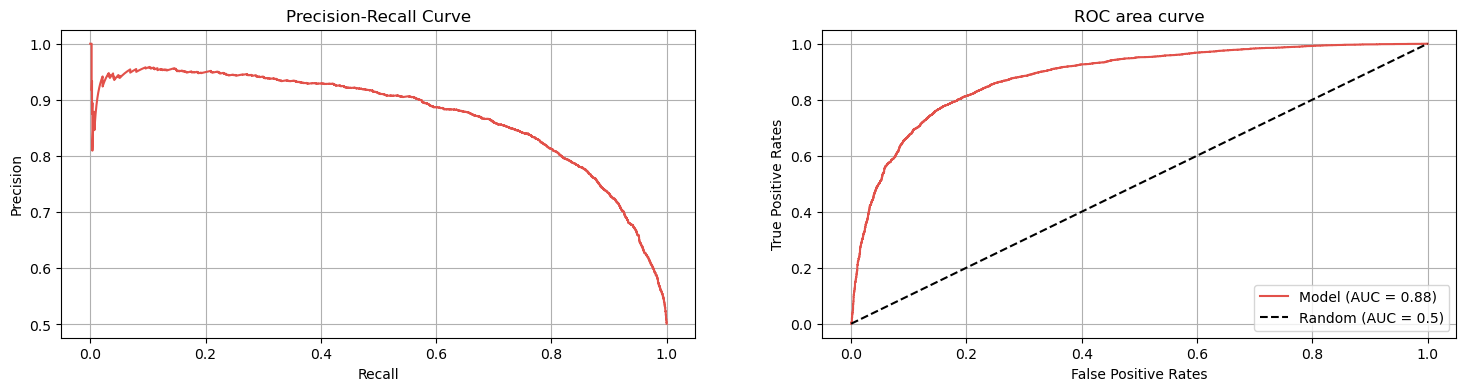

In [9]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

EvaluationPlots.plot_precision_recall_curve(y_test, sklearn_probabilities[:, 1], ax=axes[0])
EvaluationPlots.plot_roc_area_curve(y_test, sklearn_probabilities[:, 1], ax=axes[1])

# <center> Compare scores </center>

In [10]:
from sklearn.metrics import recall_score, precision_score

custom_accuracy = accuracy_score(y_test, custom_predictions)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)

custom_recall = recall_score(y_test, custom_predictions)
sklearn_recall = recall_score(y_test, sklearn_predictions)

custom_precision = precision_score(y_test, custom_predictions)
sklearn_precision = precision_score(y_test, sklearn_predictions)

custom_f1 = f1_score(y_test, custom_predictions)
sklearn_f1 = f1_score(y_test, sklearn_predictions)

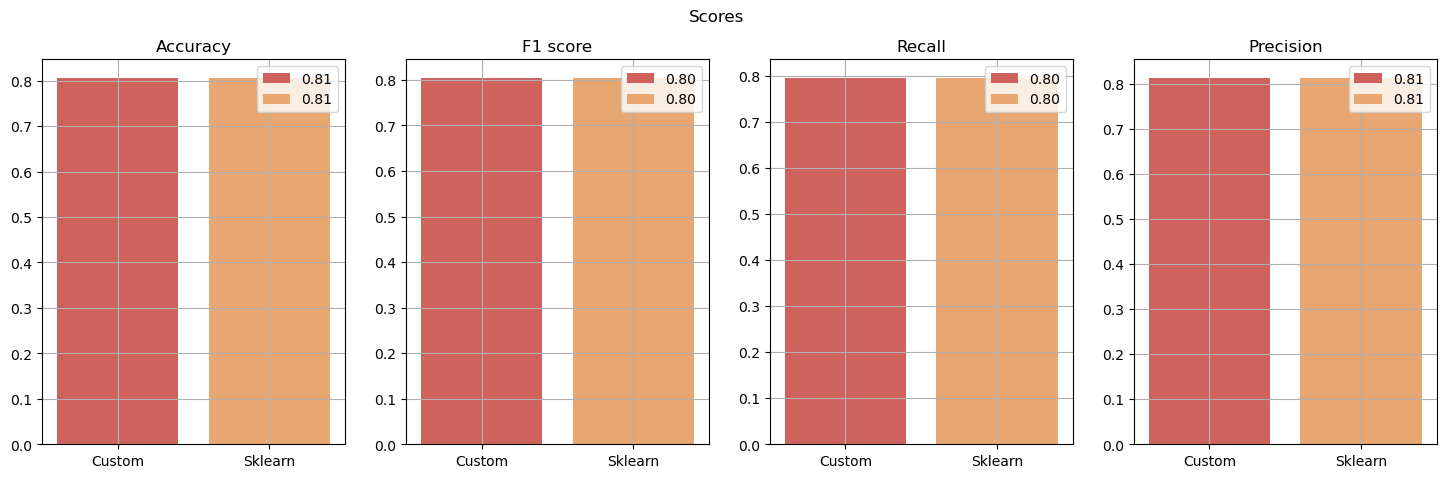

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))

sns.barplot(x=['Custom'], y=custom_accuracy, label=f'{custom_accuracy:.2f}', ax=ax[0])
sns.barplot(x=['Sklearn'], y=sklearn_accuracy, label=f'{sklearn_accuracy:.2f}',ax=ax[0])


sns.barplot(x=['Custom'], y=custom_f1, label=f'{custom_f1:.2f}', ax=ax[1])
sns.barplot(x=['Sklearn'], y=sklearn_f1, label=f'{sklearn_f1:.2f}',ax=ax[1])


sns.barplot(x=['Custom'], y=custom_recall, label=f'{custom_recall:.2f}', ax=ax[2])
sns.barplot(x=['Sklearn'], y=sklearn_recall, label=f'{sklearn_recall:.2f}',ax=ax[2])


sns.barplot(x=['Custom'], y=custom_precision, label=f'{custom_precision:.2f}', ax=ax[3])
sns.barplot(x=['Sklearn'], y=sklearn_precision, label=f'{sklearn_precision:.2f}',ax=ax[3])


fig.suptitle('Scores')
ax[0].grid(True); ax[0].set_title('Accuracy')
ax[1].grid(True); ax[1].set_title('F1 score')
ax[2].grid(True); ax[2].set_title('Recall')
ax[3].grid(True); ax[3].set_title('Precision');

# <center> Validation Curve </center>

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type pr

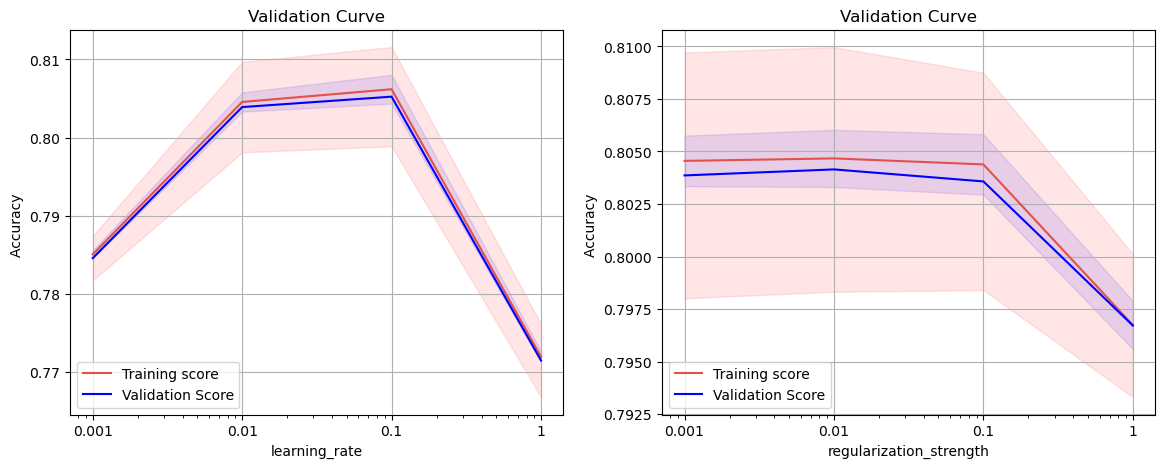

In [12]:
from sklearn.model_selection import validation_curve

log_reg_1 = CustomLogisticRegression(number_of_epochs=500)
log_reg_2 = CustomLogisticRegression(number_of_epochs=500, regularize=True)

def plot_validation_curve(model, X, y, param_name, param_range, cv=5, ax=None, scoring='accuracy'):
    train_scores, validation_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(validation_scores, axis=1)
    val_std = np.std(validation_scores, axis=1)

    if ax is None:
        ax = plt.gca()

    
    ax.plot(param_range, train_mean, label='Training score')
    ax.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                    alpha=0.1, color='blue')

    # Plot validation scores
    ax.plot(param_range, val_mean, label='Validation Score', color='blue')
    ax.fill_between(param_range, val_mean - val_std, val_mean + val_std, 
                    alpha=0.1, color='red')

    # Formatting
    ax.set_xscale('log')  # Important for C values!
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:g}'))
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel(f'{scoring.replace('_', ' ').title()} ')
    ax.set_title('Validation Curve')
    ax.legend()
    ax.grid()

param_range = [0.001, 0.01, 0.1, 1]

figure, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_validation_curve(
    log_reg_1, X_train, y_train, param_name='learning_rate', param_range=param_range, cv=5, ax=axes[0]
)

plot_validation_curve(
    log_reg_2, X_train, y_train, param_name='regularization_strength', param_range=param_range, cv=5, ax=axes[1]
)

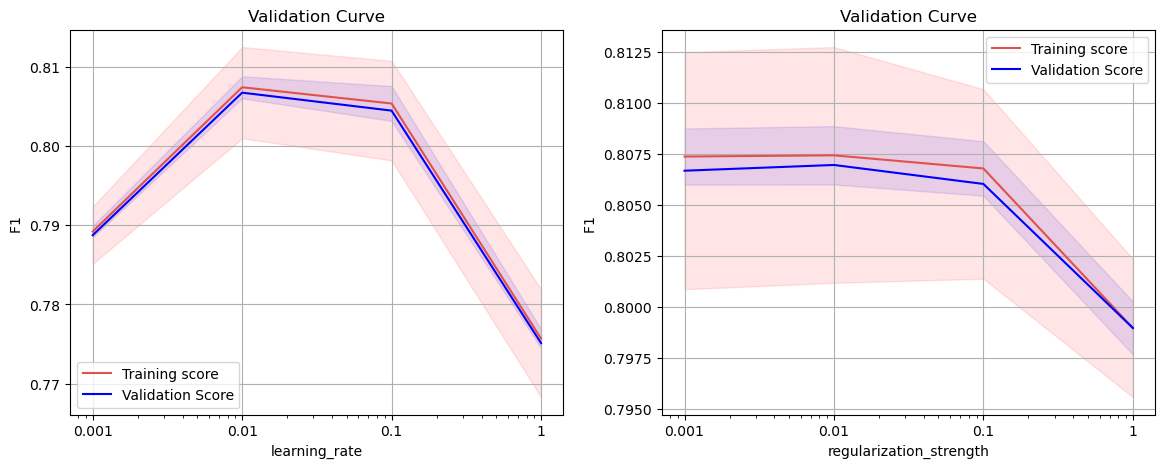

In [13]:
param_range = [0.001, 0.01, 0.1, 1]

figure, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_validation_curve(
    log_reg_1, X_train, y_train, param_name='learning_rate', param_range=param_range, cv=5, ax=axes[0], scoring='f1'
)

plot_validation_curve(
    log_reg_2, X_train, y_train, param_name='regularization_strength', param_range=param_range, cv=5, ax=axes[1], scoring='f1'
)

* In this case, the optimal learning rate is showing 0.1 for Accuracy.
* It also shows the optimal learning rate for F1 is 0.01.
* So grid search between 0.01 between 0.1 is needed - [0.01, 0.05, 0.1]